# Import Libraries

In [66]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, losses, metrics, models, optimizers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, zero_one_loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Dataset

Hyperparameters

In [8]:
BATCH_SIZE = 32
EPOCH = 10
LEARNING_RATE = 0.001

In [9]:
# Directiories
dataset_dir = '../data/processed'
model_dir = '../models'

train_dir = f'{dataset_dir}/train'
val_dir = f'{dataset_dir}/valid'
test_dir = f'{dataset_dir}/test'

train_img_dir = f'{train_dir}/images'
val_img_dir = f'{val_dir}/images'
test_img_dir = f'{test_dir}/images'

# Label files
df_train = pd.read_csv(f'{train_dir}/labels.csv')
df_val = pd.read_csv(f'{val_dir}/labels.csv')
df_test = pd.read_csv(f'{test_dir}/labels.csv')

df_train.columns = [df_train.columns[0]] + [col[1:] for col in df_train.columns[1:]]
df_val.columns = [df_val.columns[0]] + [col[1:] for col in df_val.columns[1:]]
df_test.columns = [df_test.columns[0]] + [col[1:] for col in df_test.columns[1:]]

# Dataset metadata
NUM_CLASSES = len(df_train.columns) - 1
DATASET_COLS = [str(obj) for obj in df_train.columns[1:]]

# Generate data from DataFrames
SEED = 42
WIDTH, HEIGHT = 224, 224
datagen = ImageDataGenerator()

train_ds = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
val_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
test_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=1,
    seed=SEED,
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    class_mode=None
)

Found 5916 validated image filenames.
Found 123 validated image filenames.
Found 123 validated image filenames.


# Build Model

Load model (optional)

In [6]:
emeowtions_model = keras.saving.load_model(f'{model_dir}/checkpoints/emeowtionsv1.keras')

https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

In [65]:
# Load pre-trained model
mobilenetv3_small = keras.applications.MobileNetV3Small(
    weights='imagenet', # Load pre-trained weights from ImageNet
    input_shape=(224, 224, 3),
    include_top=False   # Exclude ImageNet top classifiers
)

# Freeze base model
mobilenetv3_small.trainable = False

# Build custom multi-label classification mode on top of the MobileNetV3 base model,
# this replaces the top layers of the base model
emeowtions_model = keras.models.Sequential([
    mobilenetv3_small,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

# Compile model
emeowtions_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(from_logits=False),   # try w/ and w/o logits
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Precision(),
        metrics.Recall(),
        metrics.AUC()
    ]
)

# Train custom layers
history = emeowtions_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=2
)

Epoch 1/10
185/185 - 88s - 476ms/step - accuracy: 0.0000e+00 - loss: 0.3208 - val_accuracy: 0.0000e+00 - val_loss: 0.2889
Epoch 2/10
185/185 - 63s - 338ms/step - accuracy: 0.0000e+00 - loss: 0.2107 - val_accuracy: 0.0000e+00 - val_loss: 0.2822
Epoch 3/10
185/185 - 64s - 347ms/step - accuracy: 0.0000e+00 - loss: 0.1688 - val_accuracy: 0.0000e+00 - val_loss: 0.2780
Epoch 4/10
185/185 - 46s - 251ms/step - accuracy: 0.0000e+00 - loss: 0.1389 - val_accuracy: 0.0000e+00 - val_loss: 0.2804
Epoch 5/10
185/185 - 41s - 220ms/step - accuracy: 0.0000e+00 - loss: 0.1163 - val_accuracy: 0.0000e+00 - val_loss: 0.2945
Epoch 6/10
185/185 - 47s - 254ms/step - accuracy: 2.8172e-05 - loss: 0.0970 - val_accuracy: 0.0000e+00 - val_loss: 0.2967
Epoch 7/10
185/185 - 61s - 331ms/step - accuracy: 9.3907e-05 - loss: 0.0813 - val_accuracy: 0.0000e+00 - val_loss: 0.3095
Epoch 8/10
185/185 - 66s - 358ms/step - accuracy: 1.9721e-04 - loss: 0.0688 - val_accuracy: 0.0000e+00 - val_loss: 0.3242
Epoch 9/10
185/185 - 63s

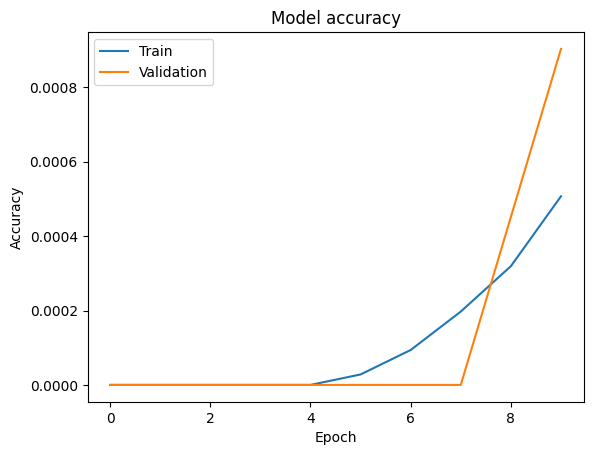

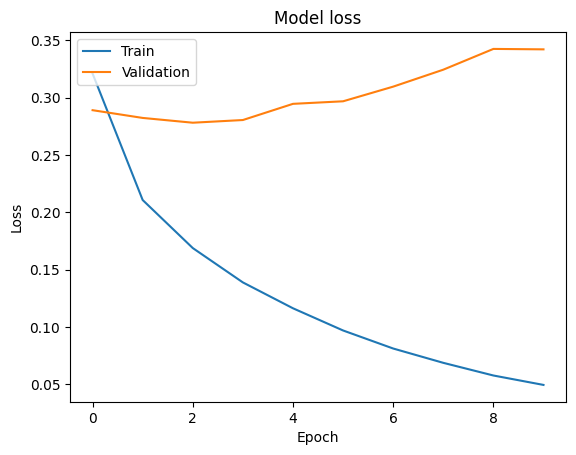

In [68]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

In [3]:
x = emeowtions_model.evaluate(
    val_ds,
    batch_size=BATCH_SIZE
)

NameError: name 'emeowtions_model' is not defined

# Prediction

Make prediction on test set

In [7]:
pred = emeowtions_model.predict(test_ds)

c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6001CEM Individual Project\emeowtions-ml\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


Helper functions

In [101]:
# Plots confusion matrix for every class
def plot_multi_cm(mcm, class_list):
    num_classes = len(class_list)

    fig, axes = plt.subplots(6, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i, cm, in enumerate(mcm):
        ax = axes[i]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar= False,
                    xticklabels=['Negative', 'Positve'], yticklabels=['Negative', 'Positve'],
                    ax=ax)
        ax.set_title(f'{class_list[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
        
# Plots AUC-PR for a single class
def plot_single_auc_pr(title, label, y_true, y_pred):
    i = DATASET_COLS.index(label)

    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'{DATASET_COLS[i]} (AUC = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title} Precision-Recall Curve')
    plt.legend()
    plt.grid()

# Plots AUC-PR for every class
def plot_multi_auc_pr(ax, title, class_set, y_true, y_pred):    
    for i in range(y_true.shape[1]):
        if DATASET_COLS[i] in class_set:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
            ax.plot(recall, precision, label=f'{DATASET_COLS[i]} (AUC = {avg_precision:.2f})')

    ax.set_title(f'{title} Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    ax.grid()

Metrics


Subset Accuracy: 0.2439
Average Precision: 0.7036
Average Recall: 0.6559
Average F1 Score: 0.6750
Hamming Loss: 0.1183
Zero-One Loss: 0.7561
Classification Report:
                        precision    recall  f1-score   support

                angry       0.93      0.82      0.88        17
            ears_flat       0.75      0.50      0.60        24
              ears_up       0.80      0.78      0.79        72
    eyes_large_pupils       0.69      0.81      0.75        31
        eyes_narrowed       0.56      0.48      0.52        29
    eyes_small_pupils       0.66      0.50      0.57        42
                happy       0.89      0.81      0.85        48
          mouth_fangs       0.69      0.65      0.67        17
              neutral       0.62      0.61      0.62        33
  posture_arched_back       0.73      0.89      0.80         9
posture_exposed_belly       0.82      0.75      0.78        12
      posture_neutral       0.60      0.63      0.62        19
        postur

c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6001CEM Individual Project\emeowtions-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


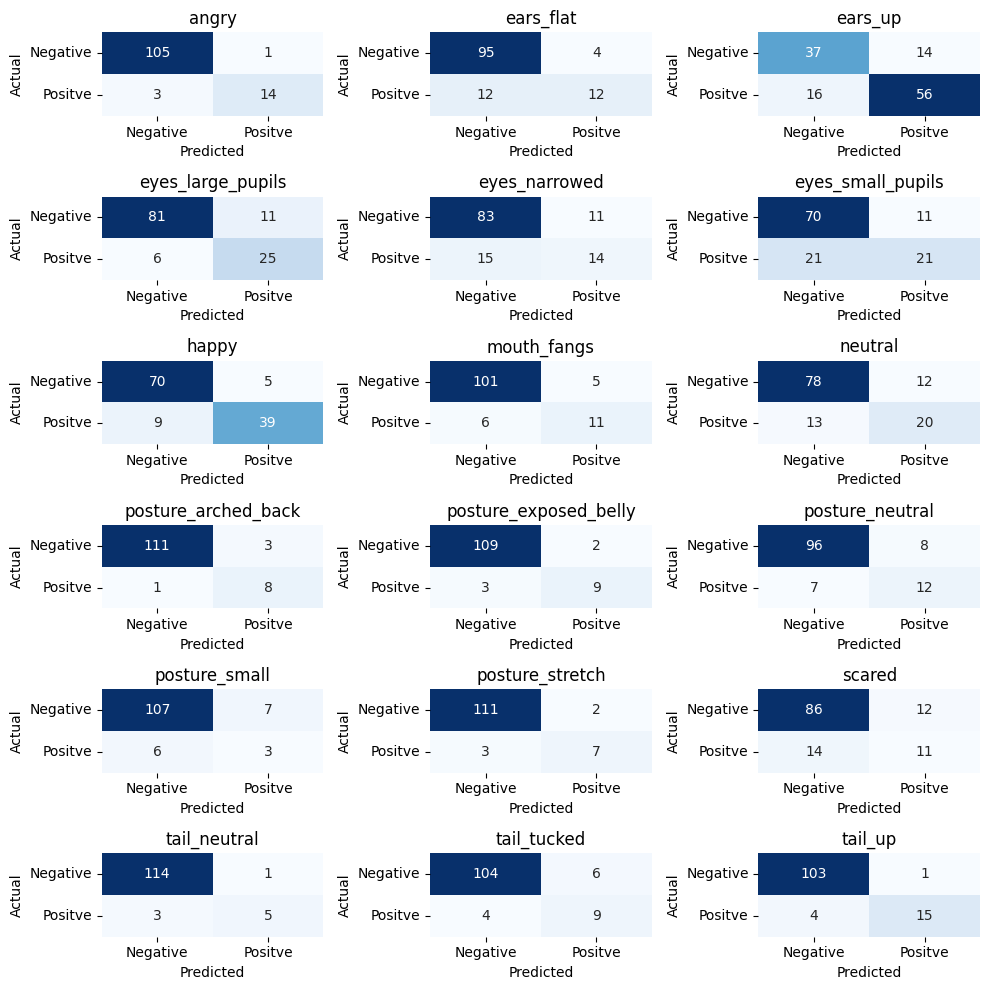

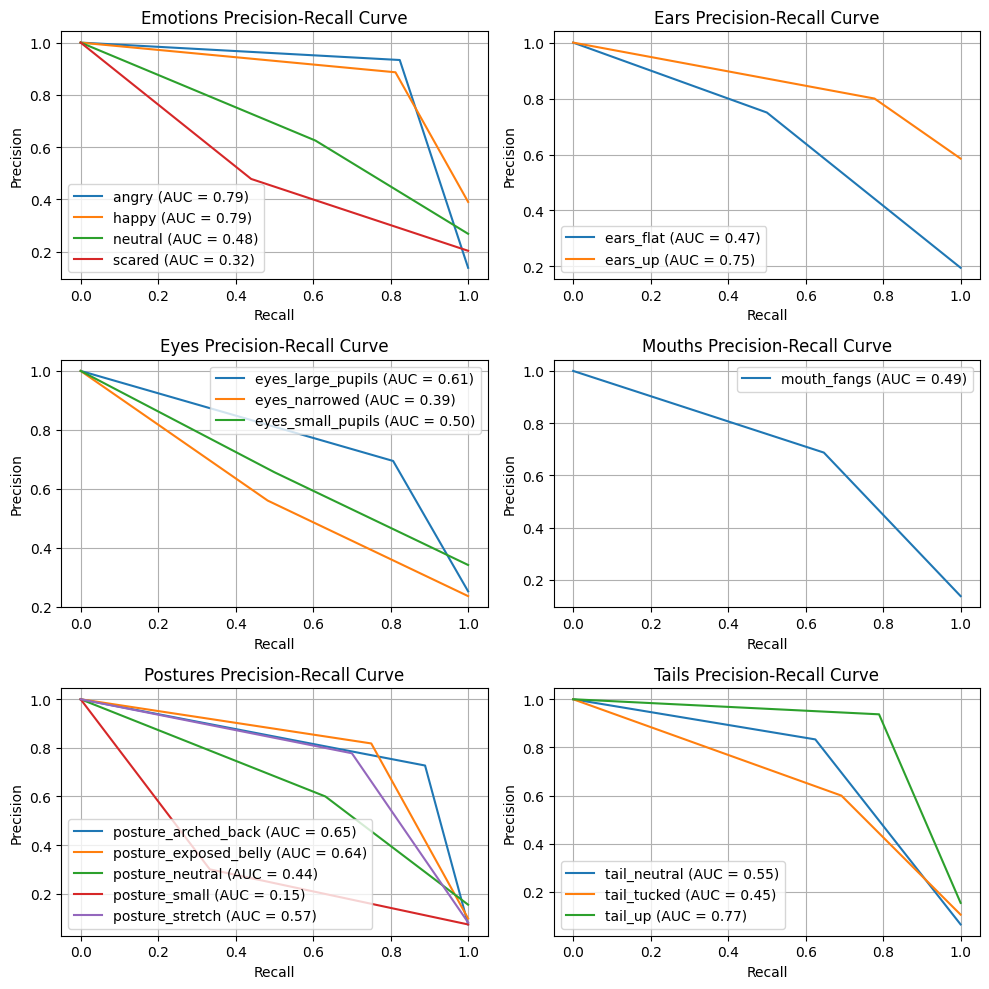

In [116]:
# Get ground truth labels
labels_true = df_test.drop(columns=['filename']).values

# Print predictions
binary_pred = (pred > 0.5).astype(int)
#print('Prediction Probabilities:\n', pred)
#print('\nBinary Predictions:\n', binary_pred)

# Calculate metrics
subset_accuracy = accuracy_score(labels_true, binary_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_true, binary_pred, average=None)
hamming = hamming_loss(labels_true, binary_pred)
zero_one = zero_one_loss(labels_true, binary_pred)

# Display metrics
print(f'\nSubset Accuracy: {subset_accuracy:.4f}')
#print(f'Precision per label: {precision}')
#print(f'Recall per label: {recall}')
#print(f'F1 Score per label: {f1}')
print(f'Average Precision: {precision.mean():.4f}')
print(f'Average Recall: {recall.mean():.4f}')
print(f'Average F1 Score: {f1.mean():.4f}')
print(f'Hamming Loss: {hamming:.4f}')
print(f'Zero-One Loss: {zero_one:.4f}')


# Visualizations
# Class sets
emotions = ['angry', 'happy', 'neutral', 'scared']
ears = ['ears_flat', 'ears_up']
eyes = ['eyes_large_pupils', 'eyes_narrowed', 'eyes_small_pupils']
mouths = ['mouth_fangs']
postures = ['posture_arched_back', 'posture_exposed_belly', 'posture_neutral', 'posture_small', 'posture_stretch']
tails = ['tail_neutral', 'tail_tucked', 'tail_up']

# Confusion matrix
confusion_matrices = multilabel_confusion_matrix(labels_true, binary_pred)
classification_report = skm.classification_report(labels_true, binary_pred, target_names=DATASET_COLS)
print('Classification Report:\n', classification_report)
plot_multi_cm(confusion_matrices, DATASET_COLS)

# AUC-PR
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

plot_multi_auc_pr(axes[0], 'Emotions', emotions, labels_true, binary_pred)
plot_multi_auc_pr(axes[1], 'Ears', ears, labels_true, binary_pred)
plot_multi_auc_pr(axes[2], 'Eyes', eyes, labels_true, binary_pred)
plot_multi_auc_pr(axes[3], 'Mouths', mouths, labels_true, binary_pred)
plot_multi_auc_pr(axes[4], 'Postures', postures, labels_true, binary_pred)
plot_multi_auc_pr(axes[5], 'Tails', tails, labels_true, binary_pred)

plt.tight_layout()
plt.show()

# Save

In [118]:
# Save classification report
report = skm.classification_report(labels_true, binary_pred, target_names=DATASET_COLS, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)
df_report.to_csv(f'{model_dir}/reports/emeowtionsv1.csv')

                       precision    recall  f1-score  support
angry                   0.933333  0.823529  0.875000     17.0
ears_flat               0.750000  0.500000  0.600000     24.0
ears_up                 0.800000  0.777778  0.788732     72.0
eyes_large_pupils       0.694444  0.806452  0.746269     31.0
eyes_narrowed           0.560000  0.482759  0.518519     29.0
eyes_small_pupils       0.656250  0.500000  0.567568     42.0
happy                   0.886364  0.812500  0.847826     48.0
mouth_fangs             0.687500  0.647059  0.666667     17.0
neutral                 0.625000  0.606061  0.615385     33.0
posture_arched_back     0.727273  0.888889  0.800000      9.0
posture_exposed_belly   0.818182  0.750000  0.782609     12.0
posture_neutral         0.600000  0.631579  0.615385     19.0
posture_small           0.300000  0.333333  0.315789      9.0
posture_stretch         0.777778  0.700000  0.736842     10.0
scared                  0.478261  0.440000  0.458333     25.0
tail_neu

c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6001CEM Individual Project\emeowtions-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [152]:
# Save model
emeowtions_model.save(f'{model_dir}/checkpoints/emeowtionsv1.keras')